Ps:2.240132999853228±0.0029879179718950437

As:2.3120285606032938±0.0029285851726167417

In [134]:
import numpy as npy
import scipy.optimize as opt
import matplotlib.pyplot as plt

class currentProfile:
    def __init__(self, label):
        self.label=label
        self.current=[]

def dataReader(filename, label):
    inputfile=open(filename,'r')
    outputData=currentProfile(label)
    currentData=[]
    while(1):
        try:
            temp=next(inputfile).split()
            if(temp[4]==str(label)):
                outputData.current.append(1e6*float(temp[2]))
        except StopIteration:
            outputData.current=npy.array(outputData.current)
            break
    return outputData

def fitFunc(time, omega, gamma, tanPsi, cosDelta):
    Ps=-2.240132999853228
    As=2.3120285606032938
    f0=npy.cos(Ps)**2 * tanPsi**2 +  npy.sin(Ps)**2
    f1=npy.cos(Ps)**2 * tanPsi**2 -  npy.sin(Ps)**2
    f2=npy.sin(2*Ps)*tanPsi*cosDelta
    return gamma*(f0+f1*npy.cos(2*(omega*time-As))+f2*npy.sin(2*(omega*time-As)))

def refractionRate(tanPsi, cosDelta):
    rho = tanPsi*(cosDelta-1j*npy.sqrt(1-cosDelta**2))
    return npy.sqrt(npy.sin(65.0/180.0*npy.pi)**2*(1+(npy.tan(65.0/180.0*npy.pi))**2*((1-rho)/(1+rho))**2))
 

In [135]:

wavelengths=[205+10*i for i in range(int((295-205)/10+1))]
wavelengths=wavelengths+[200+10*i for i in range(int((400-200)/10+1))]
measurements=[]
monitors=[]
length=len(wavelengths)
for i in range(length):
    measurements.append(dataReader("dataLAB/measurement.txt",wavelengths[i]))
    monitors.append(dataReader("dataLAB/monitor.txt",wavelengths[i]))

darkCurrent=dataReader("dataLAB/measurement1.txt","dark")

In [136]:
ratios=[]
fitParameters=[]
fitParametersCOV=[]
minLength=360
for i in range(length):
    ratios.append((measurements[i].current[:minLength]-npy.average(darkCurrent.current))/monitors[i].current[:minLength])
    time=npy.array([0.5*j for j in range(minLength)])
    popt,pcov=opt.curve_fit(fitFunc, time, ratios[i], p0=[0.017, 2.5, 0.1, 0.99],maxfev=1000000)
    fitParameters.append(popt)
    fitParametersCOV.append(pcov)
    fitRatio=fitFunc(time,*popt)
    fig,axs=plt.subplots(2,1)
    axs[0].plot(time,ratios[i],label="Intensity")
    axs[0].plot(time,fitRatio,label="Fitted")
    axs[1].plot(time,(ratios[i]-fitRatio)/ratios[i],label="Residual")
    axs[1].set_xlabel("Time (s)")
    axs[0].set_ylabel("Intensity")
    axs[1].set_ylabel("Residual")
    axs[0].legend()
    axs[1].legend()
    axs[0].set_title(str(measurements[i].label)+"nm")
    fig.tight_layout()
    fig.savefig("figure/RatioVsTime"+str(measurements[i].label)+"nm.jpg",dpi=500)
    plt.close()


Text(0.5, 0, 'Wavelengths')

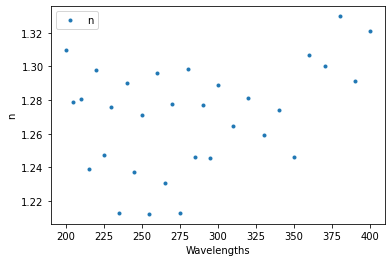

In [140]:
n=[npy.real(refractionRate(fitParameters[i][2],fitParameters[i][3])) for i in range(len(fitParameters))]
k=[npy.imag(refractionRate(fitParameters[i][2],fitParameters[i][3])) for i in range(len(fitParameters))]
# print([str(200+i*5)+"nm;"+str(fitParameters[i][2])+" "+str(fitParameters[i][3]) for i in range(len(fitParameters))])
plt.plot(wavelengths, n, '.', label='n')
plt.ylabel("n")
plt.legend()
plt.xlabel("Wavelengths")